# Import packages

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_rows", 100)

# Model classes

In [2]:
S_E = 100/4

class Skill:
    def __init__(self, mu=100, var=100):
        self.mu = mu
        self.var = var


class Team:
    def __init__(self, name, skill):
        self.name = name
        self.skill = skill

    def predict(self, another):
        lose_rate = stats.norm.cdf(x=0,
                                   loc=self.skill.mu - another.skill.mu,
                                   scale=(self.skill.var + another.skill.var + S_E) ** 0.5)
        win_rate = 1 - lose_rate
        return win_rate

    def update(self, another, result, num_samples=3000, drops=1000):
        posterior = []
        post_weights = []
        s1 = self.skill.mu
        s1_w = self.skill.var

        for _ in range(num_samples):
            s2 = stats.norm.rvs(another.skill.mu, another.skill.var ** 0.5)
            s2_w = self._importance(s1, s2, result)

            posterior.append((s1, s2))
            post_weights.append((s1_w, s2_w))

            s1 = stats.norm.rvs(self.skill.mu, self.skill.var ** 0.5)
            s1_w = self._importance(s1, s2, result)

        posterior = np.array(posterior)
        post_weights = np.array(post_weights)

        self.skill.mu, self.skill.var = self._approx_gaussian(posterior[drops:, 0], post_weights[drops:, 0])
        another.skill.mu, another.skill.var = self._approx_gaussian(posterior[drops:, 1], post_weights[drops:, 1])

    @staticmethod
    def _approx_gaussian(samples, importances):
        mu = np.average(samples, weights=importances)
        var = np.average((samples - mu) ** 2, weights=importances)
        return mu, var

    @staticmethod
    def _importance(s1, s2, y=1):
        pr = 1 - stats.norm(s1 - s2, S_E ** 0.5).cdf(0) if y > 0 else stats.norm(s1 - s2, S_E ** 0.5).cdf(0)
        return pr

# Data preparation and exploration

In [3]:
#raw data
nba=pd.read_csv('./nba-2021-UTC.csv', sep=',', header=0)
nba

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result
0,1,1,19/10/2021 23:30,Fiserv Forum,Milwaukee Bucks,Brooklyn Nets,127 - 104
1,2,1,20/10/2021 02:00,STAPLES Center,Los Angeles Lakers,Golden State Warriors,114 - 121
2,3,1,20/10/2021 23:00,Spectrum Center,Charlotte Hornets,Indiana Pacers,123 - 122
3,4,1,20/10/2021 23:00,Little Caesars Arena,Detroit Pistons,Chicago Bulls,88 - 94
4,5,1,20/10/2021 23:30,Madison Square Garden,New York Knicks,Boston Celtics,138 - 134
...,...,...,...,...,...,...,...
1225,1220,24,11/04/2022 01:30,Ball Arena,Denver Nuggets,Los Angeles Lakers,141 - 146
1226,1222,24,11/04/2022 01:30,Crypto.com Arena,LA Clippers,Oklahoma City Thunder,138 - 88
1227,1225,24,11/04/2022 01:30,Smoothie King Center,New Orleans Pelicans,Golden State Warriors,107 - 128
1228,1229,24,11/04/2022 01:30,Footprint Center,Phoenix Suns,Sacramento Kings,109 - 116


In [4]:
nba['Home Team'].describe()

count                     1230
unique                      30
top       New Orleans Pelicans
freq                        41
Name: Home Team, dtype: object

In [5]:
# split result into team1 score and team2 score
nba['Score1']=nba['Result'].map(lambda x: x.split()[0])
nba['Score2']=nba['Result'].map(lambda x: x.split()[2])
nba

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result,Score1,Score2
0,1,1,19/10/2021 23:30,Fiserv Forum,Milwaukee Bucks,Brooklyn Nets,127 - 104,127,104
1,2,1,20/10/2021 02:00,STAPLES Center,Los Angeles Lakers,Golden State Warriors,114 - 121,114,121
2,3,1,20/10/2021 23:00,Spectrum Center,Charlotte Hornets,Indiana Pacers,123 - 122,123,122
3,4,1,20/10/2021 23:00,Little Caesars Arena,Detroit Pistons,Chicago Bulls,88 - 94,88,94
4,5,1,20/10/2021 23:30,Madison Square Garden,New York Knicks,Boston Celtics,138 - 134,138,134
...,...,...,...,...,...,...,...,...,...
1225,1220,24,11/04/2022 01:30,Ball Arena,Denver Nuggets,Los Angeles Lakers,141 - 146,141,146
1226,1222,24,11/04/2022 01:30,Crypto.com Arena,LA Clippers,Oklahoma City Thunder,138 - 88,138,88
1227,1225,24,11/04/2022 01:30,Smoothie King Center,New Orleans Pelicans,Golden State Warriors,107 - 128,107,128
1228,1229,24,11/04/2022 01:30,Footprint Center,Phoenix Suns,Sacramento Kings,109 - 116,109,116


In [6]:
(nba['Score1'].astype('int').sum()+nba['Score2'].astype('int').sum())/2460
#average score

110.6349593495935

In [7]:
nba['Score1'].astype('int').var(),nba['Score2'].astype('int').var()

(155.48693894831544, 162.37714911323238)

In [8]:
nba.loc[nba['Score1']==nba['Score2']]
#no draws, perfect dataset

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result,Score1,Score2


# Training and prediction

In [9]:
teams = {name: Team(name, Skill()) for name in nba['Home Team'].unique()}

num_predictions = 0
correct_predictions = 0

for num in nba.index:
    #load match
    match=nba[num:num+1]
    team1 = teams[match['Home Team'].item()]
    team2 = teams[match['Away Team'].item()]

    # skip draws
    if match['Score1'].astype('int').item() == match['Score2'].astype('int').item():
        continue

    num_predictions += 1
    result = 1 if match['Score1'].astype('int').item() > match['Score2'].astype('int').item() else -1
    print(f"Before match: {team1.name}: {round(team1.skill.mu, 2)}-{round(team1.skill.var, 2)} vs "
          f"{team2.name}: {round(team2.skill.mu, 2)}-{round(team2.skill.var, 2)}")
    print(f"Team 1 rate: {round(team1.predict(team2), 2)} ==================== Result: {result}")

    prediction = 1 if team1.predict(team2) >= 0.5 else -1

    correct_predictions += prediction == result
    # update skills
    team1.update(team2, result)
    print(f"After match: {team1.name}: {round(team1.skill.mu, 2)}-{round(team1.skill.var, 2)} vs "
          f"{team2.name}: {round(team2.skill.mu, 2)}-{round(team2.skill.var, 2)}")

    print("=======================================================")

correct_predictions/num_predictions

Before match: Milwaukee Bucks: 100-100 vs Brooklyn Nets: 100-100
Team 1 rate: 0.5 ==================== Result: 1
After match: Milwaukee Bucks: 105.45-68.43 vs Brooklyn Nets: 94.83-70.33
Before match: Los Angeles Lakers: 100-100 vs Golden State Warriors: 100-100
Team 1 rate: 0.5 ==================== Result: -1
After match: Los Angeles Lakers: 95.15-70.81 vs Golden State Warriors: 105.16-67.67
Before match: Charlotte Hornets: 100-100 vs Indiana Pacers: 100-100
Team 1 rate: 0.5 ==================== Result: 1
After match: Charlotte Hornets: 105.18-67.84 vs Indiana Pacers: 94.84-70.57
Before match: Detroit Pistons: 100-100 vs Chicago Bulls: 100-100
Team 1 rate: 0.5 ==================== Result: -1
After match: Detroit Pistons: 94.96-73.11 vs Chicago Bulls: 105.34-71.91
Before match: New York Knicks: 100-100 vs Boston Celtics: 100-100
Team 1 rate: 0.5 ==================== Result: 1
After match: New York Knicks: 105.4-69.5 vs Boston Celtics: 94.92-73.05
Before match: Toronto Raptors: 100-100 v

0.6170731707317073

In [10]:
skills=pd.DataFrame({'Team':teams.keys()})
skills['Mean']=[teams[skills['Team'][i:i+1].item()].skill.mu for i in range(len(skills))]
skills['Varience']=[teams[skills['Team'][i:i+1].item()].skill.var for i in range(len(skills))]

In [11]:
skills['Mean'].sum()/30

100.3498147533949

In [12]:
skills['Varience'].sum()/30

0.5897568903349993

In [13]:
skills.sort_values(by='Mean',ascending=False)

,Team,Mean,Varience
11,Phoenix Suns,104.763397,0.736525
6,Memphis Grizzlies,102.863824,0.622837
20,Philadelphia 76ers,102.479595,0.704090
14,Miami Heat,102.413762,0.701512
29,Dallas Mavericks,102.352059,0.598181
19,Boston Celtics,102.185124,0.387102
0,Milwaukee Bucks,102.015488,0.500322
15,Golden State Warriors,101.909062,0.686742
23,Denver Nuggets,101.590393,0.620741
5,Toronto Raptors,101.581880,0.542555


In [14]:
skills.to_csv('skill_nba.csv',index=False)

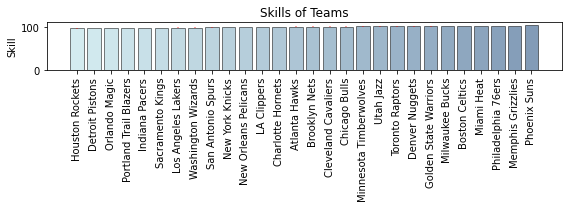

In [15]:
from matplotlib import pyplot
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]


def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]


data = pd.read_csv('skill_nba.csv', sep=',', header=0).to_numpy()[:-2, :]

data = data[data[:, 1].argsort()]

figure(figsize=(8, 3))

color1 = "#abdbe3"
color2 = "#063970"


pyplot.bar(data[:, 0], data[:, 1], yerr=data[:, 2], alpha=0.5, align='center',
           color=get_color_gradient(color1, color2, len(data[:, 0])), edgecolor="black",
           error_kw=dict(ecolor='red', alpha=0.5))
pyplot.xticks(rotation=90)
pyplot.ylabel("Skill")
pyplot.title("Skills of Teams")

# Save the figure and show
pyplot.tight_layout()
pyplot.savefig('skill_ranking_nba.pdf', dpi=500)

In [16]:
## run another round using different order

nba=nba.sample(frac=1)

teams = {name: Team(name, Skill()) for name in nba['Home Team'].unique()}

num_predictions = 0
correct_predictions = 0

for num in nba.index:
    #load match
    match=nba[num:num+1]
    team1 = teams[match['Home Team'].item()]
    team2 = teams[match['Away Team'].item()]

    # skip draws
    if match['Score1'].astype('int').item() == match['Score2'].astype('int').item():
        continue

    num_predictions += 1
    result = 1 if match['Score1'].astype('int').item() > match['Score2'].astype('int').item() else -1
    print(f"Before match: {team1.name}: {round(team1.skill.mu, 2)}-{round(team1.skill.var, 2)} vs "
          f"{team2.name}: {round(team2.skill.mu, 2)}-{round(team2.skill.var, 2)}")
    print(f"Team 1 rate: {round(team1.predict(team2), 2)} ==================== Result: {result}")

    prediction = 1 if team1.predict(team2) >= 0.5 else -1

    correct_predictions += prediction == result
    # update skills
    team1.update(team2, result)
    print(f"After match: {team1.name}: {round(team1.skill.mu, 2)}-{round(team1.skill.var, 2)} vs "
          f"{team2.name}: {round(team2.skill.mu, 2)}-{round(team2.skill.var, 2)}")

    print("=======================================================")


Before match: Utah Jazz: 100-100 vs Washington Wizards: 100-100
Team 1 rate: 0.5 ==================== Result: -1
After match: Utah Jazz: 95.01-68.62 vs Washington Wizards: 105.31-71.39
Before match: Detroit Pistons: 100-100 vs Phoenix Suns: 100-100
Team 1 rate: 0.5 ==================== Result: -1
After match: Detroit Pistons: 95.29-68.46 vs Phoenix Suns: 105.46-72.09
Before match: Boston Celtics: 100-100 vs Phoenix Suns: 105.46-72.09
Team 1 rate: 0.35 ==================== Result: 1
After match: Boston Celtics: 108.07-69.88 vs Phoenix Suns: 100.12-60.0
Before match: Dallas Mavericks: 100-100 vs Chicago Bulls: 100-100
Team 1 rate: 0.5 ==================== Result: 1
After match: Dallas Mavericks: 105.43-75.18 vs Chicago Bulls: 94.53-74.98
Before match: Memphis Grizzlies: 100-100 vs Cleveland Cavaliers: 100-100
Team 1 rate: 0.5 ==================== Result: 1
After match: Memphis Grizzlies: 105.56-74.21 vs Cleveland Cavaliers: 94.65-77.61
Before match: Atlanta Hawks: 100-100 vs Sacramento K

In [17]:
correct_predictions/num_predictions

0.624390243902439

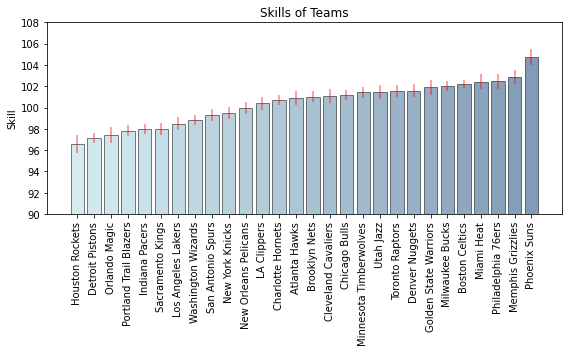

In [14]:
from matplotlib import pyplot
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]


def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]


data = pd.read_csv('skill_nba.csv', sep=',', header=0).to_numpy()[:-2, :]

data = data[data[:, 1].argsort()]

figure(figsize=(8, 5))

color1 = "#abdbe3"
color2 = "#063970"


pyplot.bar(data[:, 0], data[:, 1], yerr=data[:, 2], alpha=0.5, align='center',
           color=get_color_gradient(color1, color2, len(data[:, 0])), edgecolor="black",
           error_kw=dict(ecolor='red', alpha=0.5))
pyplot.xticks(rotation=90)
pyplot.ylim(90,108)
pyplot.ylabel("Skill")
pyplot.title("Skills of Teams")

# Save the figure and show
pyplot.tight_layout()
pyplot.savefig('skill_ranking_nba.pdf', dpi=500)